In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df_samples = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

In [3]:
# Select the columns that are listed above
df_samples = df_samples[['sample', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df_samples.columns = ['sample', '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

# Remove "_TCRB" part from the sample name
df_samples['sample'] = df_samples['sample'].map(lambda x: x.rstrip('_TCRB'))

# Create a dataframe with reads count for each sample
df_reads = df_samples.groupby(['sample', 'hospitalized']).agg({'#count': 'sum'}).reset_index().rename(columns={'#count': "count"})

# Calculate clonotype frequency
df_samples = pd.merge(df_samples, df_reads, how='outer', on=['sample','hospitalized']).fillna(0)
df_samples['freq'] = df_samples['#count'] / (df_samples['count'] * 1.0)
df_samples.fillna(0, inplace=True)

# Create a dataframe with clonotype count for each sample
df_diversity = df_samples.groupby(['sample', 'hospitalized'], sort=False).size().reset_index(name='clonotype_count')

# Add clonotype count of each sample as a column to create a new dataframe
df_samples = pd.merge(df_samples, df_diversity, on=['sample', 'hospitalized'])

df_samples

,sample,#count,cdr3aa,cdr3nt,v,d,j,hospitalized,count,freq,clonotype_count
0,6232BW,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.008268,218977
1,6232BW,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.006906,218977
2,6232BW,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True,439782,0.005214,218977
3,6232BW,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True,439782,0.004457,218977
4,6232BW,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True,439782,0.004311,218977
...,...,...,...,...,...,...,...,...,...,...,...
15061643,1566265BW,1,CSVEDLRGGYTF,CTGACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCT...,TCRBV29-01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061644,1566265BW,1,CASGRRGDYGYTF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061645,1566265BW,1,CASSWTGNSPLHF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,TCRBD02-01,TCRBJ01-06*02,False,758231,0.000001,453526
15061646,1566265BW,1,CASSLDWTEYYEQYF,CAGCCTGCAAAGCTTGAGGACTCGGCCGTGTATCTCTGTGCCAGCA...,TCRBV11-02*01,TCRBD01-01*01,TCRBJ02-07*01,False,758231,0.000001,453526


Prepare two dataframes for merging and analyzing the overlapping

In [4]:
# If there are more than one V or J gene, leave only the first one
df_samples['v'].str.replace("(,).*", "", regex=True)
df_samples['j'].str.replace("(,).*", "", regex=True)

df_compare = pd.merge(df_samples, df_samples, on=[
                      'cdr3nt', 'cdr3aa', 'v', 'd', 'j'], suffixes=['_1', '_2'])

df_compare = df_compare[df_compare['sample_1'] != df_compare['sample_2']]

df_compare['#count_1**2'] = df_compare['#count_1'] * df_compare['#count_1']
df_compare['#count_2**2'] = df_compare['#count_2'] * df_compare['#count_2']
df_compare['#count_1*2'] = df_compare['#count_1'] * df_compare['#count_2']

# Prepare data for future analysis
sample_names = df_samples["sample"].drop_duplicates()
sample_names_size = sample_names.size
sample_names.index = np.arange(0, sample_names_size)

samples = {}

for sample in sample_names:
    filtered_samples = df_samples.loc[(df_samples['sample'] == sample)]
    samples[sample] = filtered_samples

df_overlaps = {}

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    df_compare1 = (df_compare['sample_1'] == sample1)

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_compare2 = (df_compare['sample_2'] == sample2)

        df_rows = df_compare.loc[df_compare1 & df_compare2]
        df_overlaps[f'{sample1}:{sample2}'] = df_rows


Overlap analysis 1 - Jaccard index (result table)

In [5]:
# Create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'jaccard_index']
df_jaccard_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        jaccard_overlap = df_overlaps[f'{sample1}:{sample2}'].shape[0]

        # Calculate Jaccard Index
        jaccard = jaccard_overlap / \
            (df_sample1.shape[0] + df_sample2.shape[0] - jaccard_overlap)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jaccard_index': jaccard})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jaccard_index': jaccard})

    df_data = pd.DataFrame(data)
    df_jaccard_index = pd.concat([df_jaccard_index, df_data], copy=False, ignore_index=True)

## Figure6a - Jaccard index

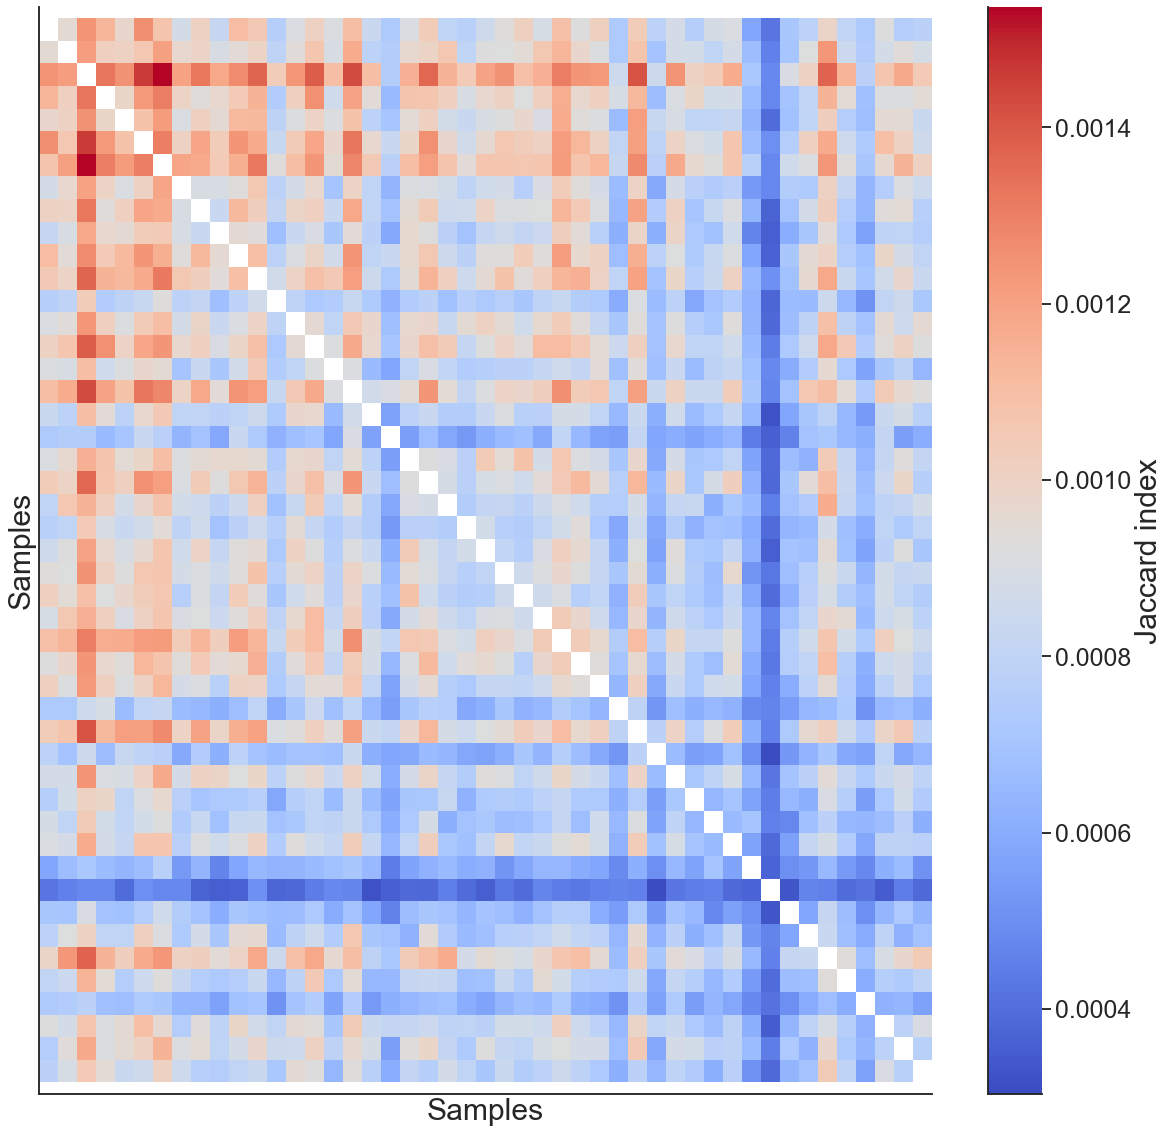

In [6]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_jaccard_index['jaccard_index'] = df_jaccard_index['jaccard_index'].astype(float)

result = df_jaccard_index.pivot(index='sample_2', columns='sample_1', values='jaccard_index')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Jaccard index'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6a.png",bbox_inches="tight")

plt.show()

Overlap analysis 2 - Overlap coefficient (result table)

In [7]:
# Create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'overlap_coefficient']
df_overlap_coefficient = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample2]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        sample_overlap = df_overlaps[f'{sample1}:{sample2}']

        # Calculate Overlap Coefficient
        overlap_coefficient = sample_overlap.shape[0] / \
            min(df_sample1.shape[0], df_sample2.shape[0])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'overlap_coefficient': overlap_coefficient})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'overlap_coefficient': overlap_coefficient})

    df_data = pd.DataFrame(data)
    df_overlap_coefficient = pd.concat([df_overlap_coefficient, df_data], copy=False, ignore_index=True)

## FigureS6b - Overlap coefficient

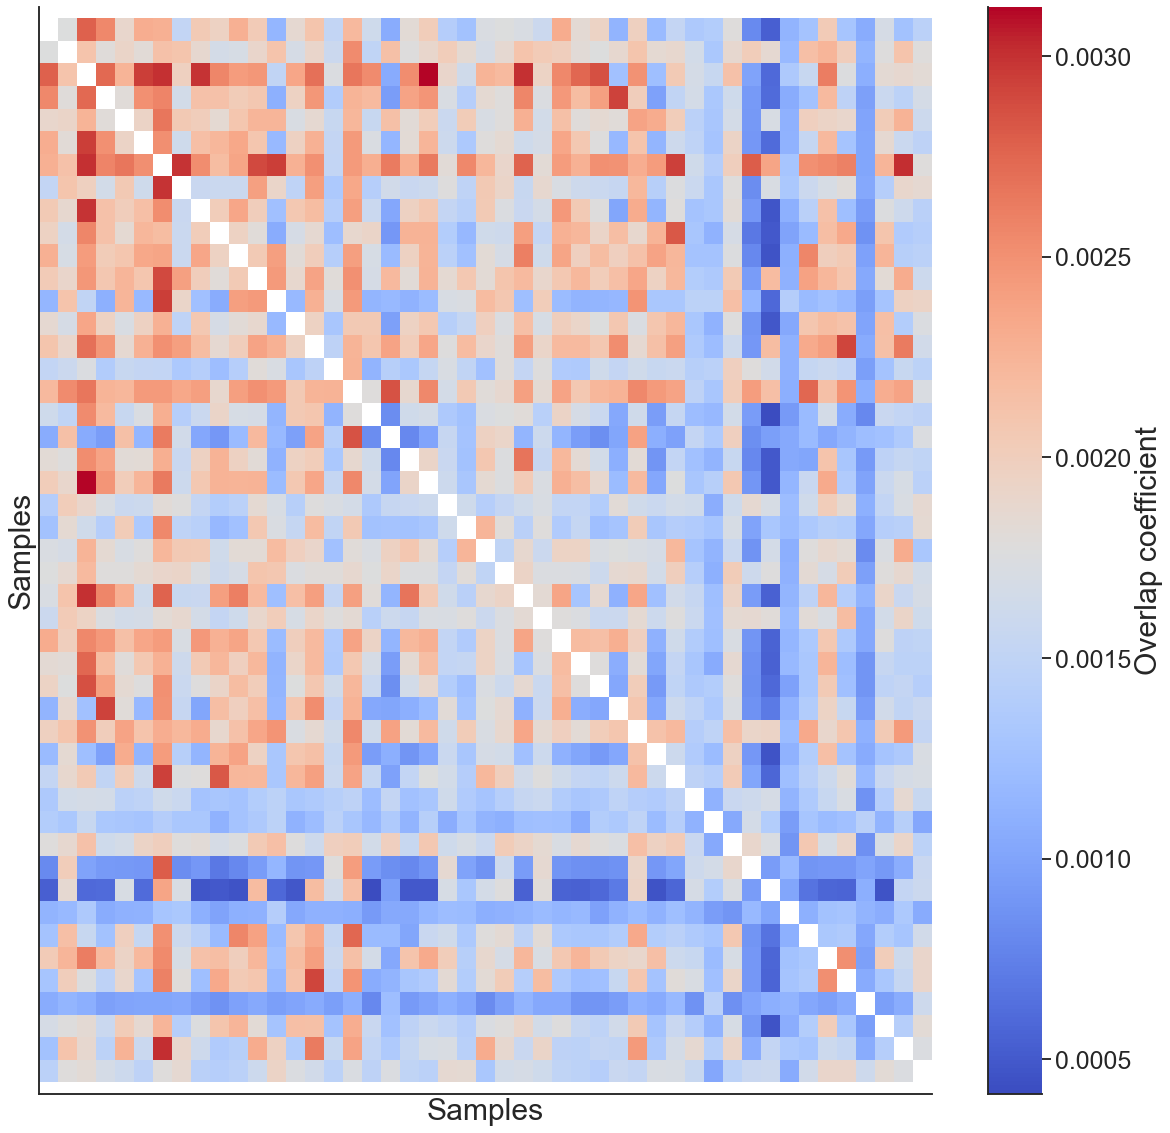

In [8]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_overlap_coefficient['overlap_coefficient'] = df_overlap_coefficient['overlap_coefficient'].astype(float)

result = df_overlap_coefficient.pivot(index='sample_2', columns='sample_1', values='overlap_coefficient')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Overlap coefficient'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6b.png",bbox_inches="tight")

plt.show()

Overlap analysis 3 - Morisita-Horn index (result table)

In [9]:
# Create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'morisita_horn_index']
df_morisita_horm_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        sum_sample_1_count = df_sample1["#count"].sum()
        sum_sample_2_count = df_sample2["#count"].sum()

        sample_overlap = df_overlaps[f'{sample1}:{sample2}']

        sum_sample_1 = sample_overlap["#count_1**2"].sum()
        sum_sample_2 = sample_overlap["#count_2**2"].sum()

        sum_count_product = sample_overlap["#count_1*2"].sum()

        # Calculate Morisita-Horn index
        step1 = (sum_sample_1 / ((sum_sample_1_count)**2)) + \
            (sum_sample_2 / ((sum_sample_2_count)**2))
        step2 = step1 * sum_sample_1_count * sum_sample_2_count
        step3 = 2 * sum_count_product
        morisita_horn_index = step3 / step2

        # Store the results
        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'morisita_horn_index': morisita_horn_index})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'morisita_horn_index': morisita_horn_index})

    df_data = pd.DataFrame(data)
    df_morisita_horm_index = pd.concat(
        [df_morisita_horm_index, df_data], copy=False, ignore_index=True)

## FigureS6c - Morisita-Horn index

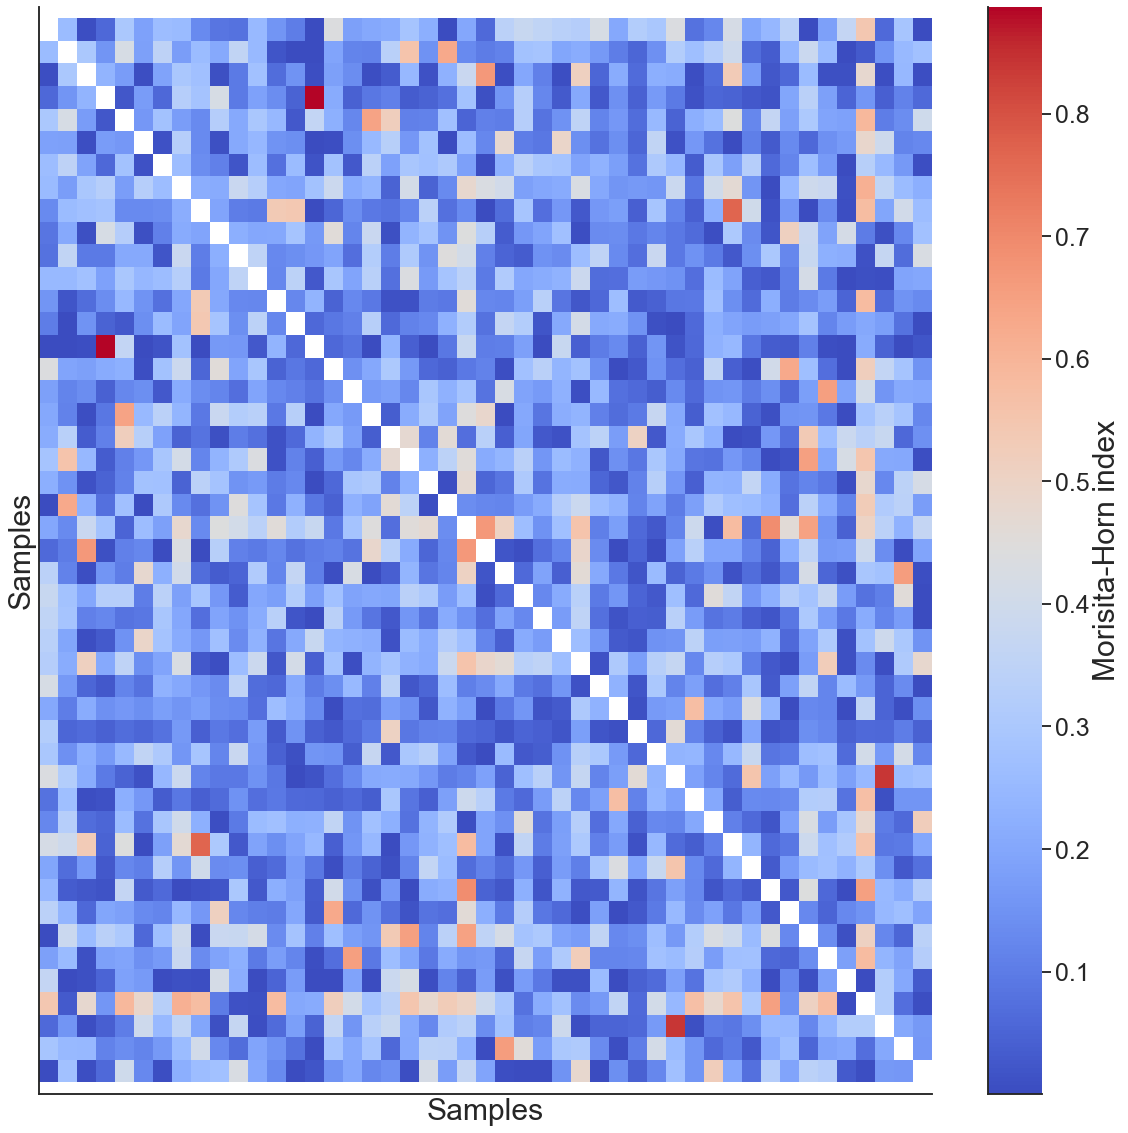

In [10]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_morisita_horm_index['morisita_horn_index'] = df_morisita_horm_index['morisita_horn_index'].astype(float)

result = df_morisita_horm_index.pivot(index='sample_2', columns='sample_1', values='morisita_horn_index')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Morisita-Horn index'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6c.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6c.png",bbox_inches="tight")

plt.show()

Overlap analysis 4 - Tversky index (result table)

In [11]:
columns = ['sample_1', 'sample_2', 'tversky_index']
df_tversky_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        tversky_index = df_overlap.shape[0] / (df_overlap.shape[0] + 0.5 * (
            df_sample1.shape[0] - df_overlap.shape[0]) + 0.5 * (df_sample2.shape[0] - df_overlap.shape[0]))

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'tversky_index': tversky_index})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'tversky_index': tversky_index})

    df_data = pd.DataFrame(data)
    df_tversky_index = pd.concat([df_tversky_index, df_data], copy=False, ignore_index=True)

## FigureS6d - Tversky index

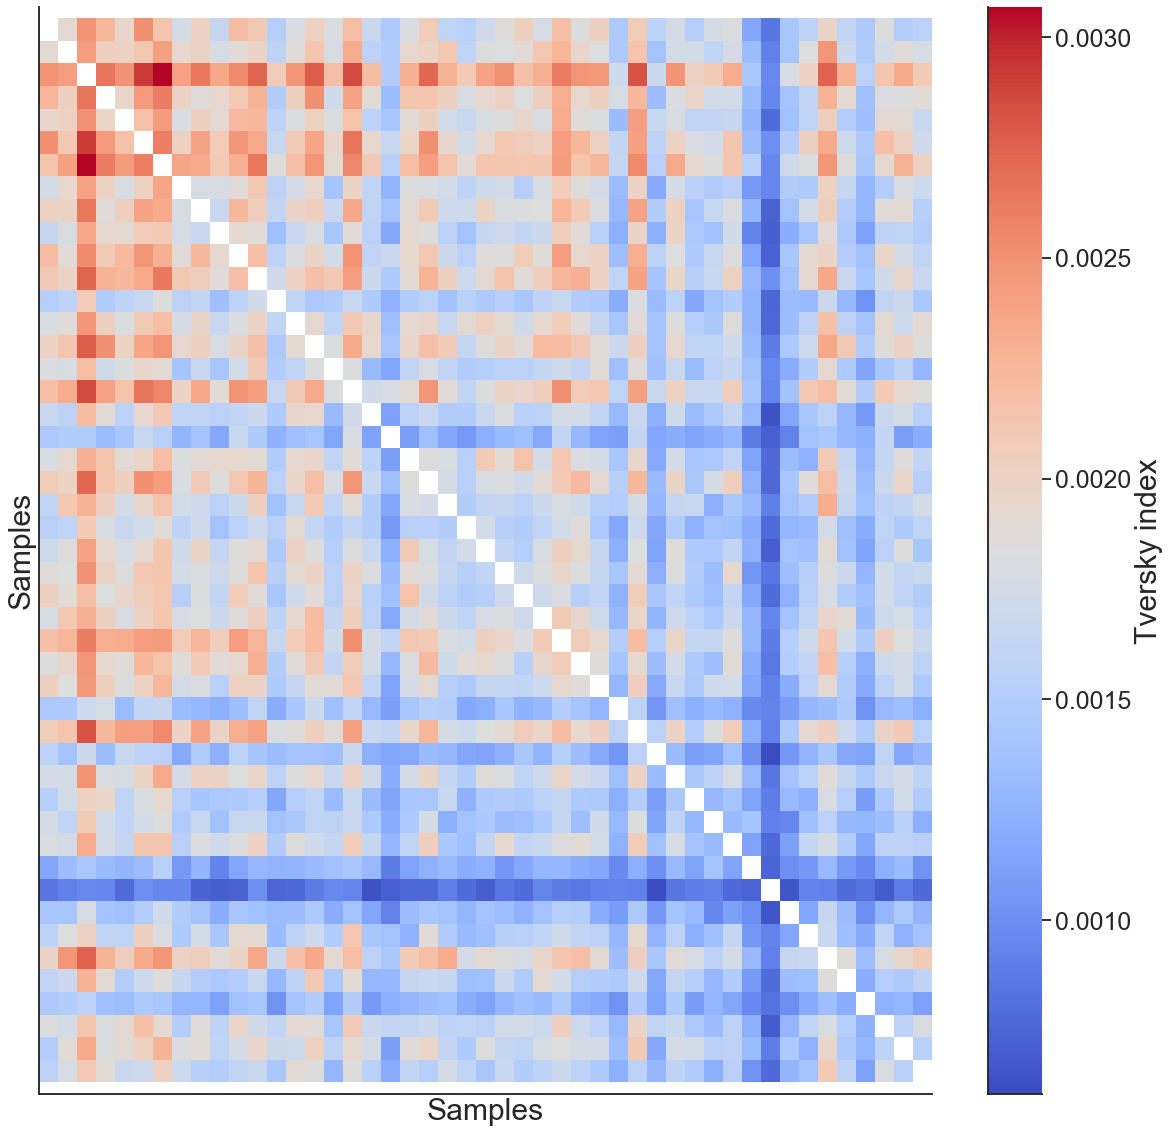

In [12]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_tversky_index['Tversky_index'] = df_tversky_index['tversky_index'].astype(float)

result = df_tversky_index.pivot(index='sample_2',columns='sample_1',values='tversky_index')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Tversky index'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6d.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6d.png",bbox_inches="tight")

plt.show()

Overlap analysis 5 - Cosine similarity (result table)

In [13]:
from scipy.spatial.distance import cosine

columns = ['sample_1', 'sample_2', 'cosine_similarity']
df_cosine_similarity = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        cos_vec = (1 - cosine(df_overlap["freq_1"], df_overlap["freq_2"]))

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'cosine_similarity': cos_vec})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'cosine_similarity': cos_vec})

    df_data = pd.DataFrame(data)
    df_cosine_similarity = pd.concat(
        [df_cosine_similarity, df_data], copy=False, ignore_index=True)

## FigureS6e - Cosine similarity

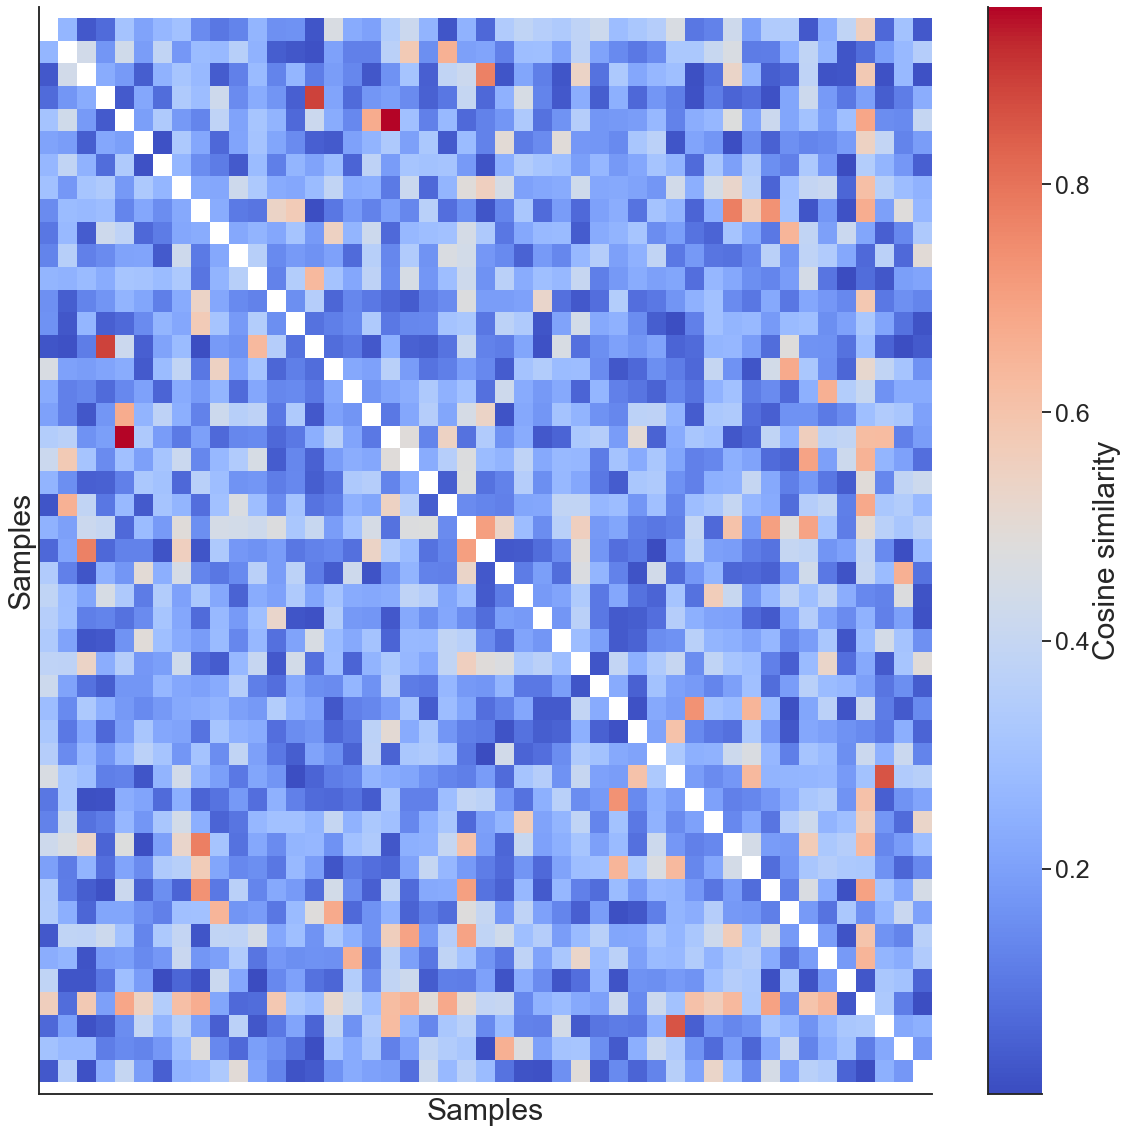

In [14]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_cosine_similarity['cosine_similarity'] = df_cosine_similarity['cosine_similarity'].astype(float)

result = df_cosine_similarity.pivot(index='sample_2', columns='sample_1', values='cosine_similarity')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Cosine similarity'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6e.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6e.png",bbox_inches="tight")

plt.show()

Overlap analysis 6.1 - Pearson correlation based on clonotype counts (result table)

In [15]:
columns = ['sample_1', 'sample_2', 'pearson_correlation']
df_pearson_correlation_count = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation = df_overlap['#count_1'].corr(
            df_overlap['#count_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'pearson_correlation': pearson_correlation})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'pearson_correlation': pearson_correlation})

    df_data = pd.DataFrame(data)
    df_pearson_correlation_count = pd.concat(
        [df_pearson_correlation_count, df_data], copy=False, ignore_index=True)

## FigureS6f - Pearson correlation based on clonotype counts

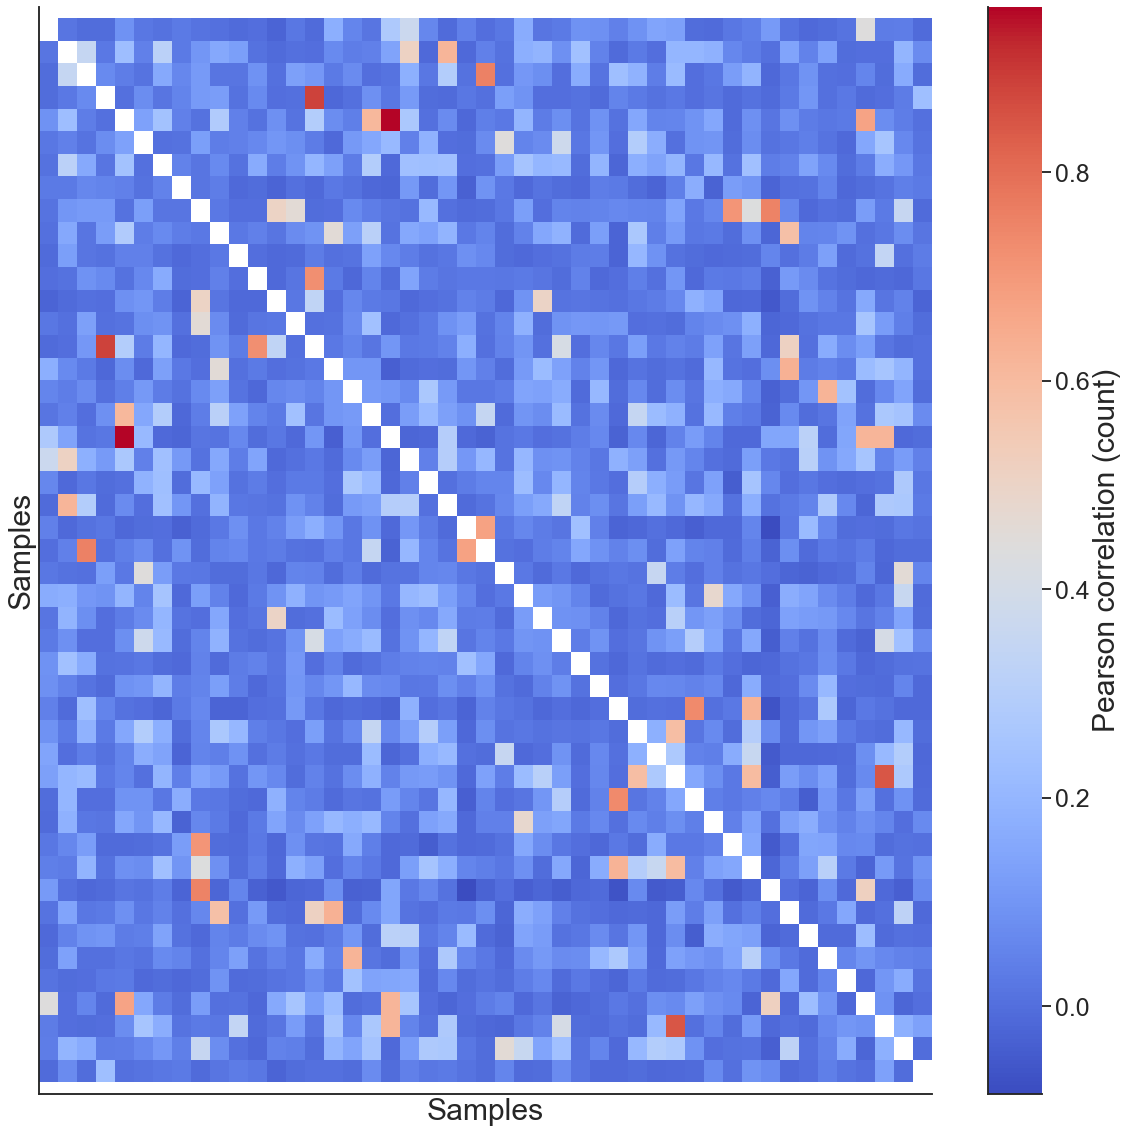

In [16]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_pearson_correlation_count['pearson_correlation'] = df_pearson_correlation_count['pearson_correlation'].astype(float)

result = df_pearson_correlation_count.pivot(index='sample_2', columns='sample_1', values='pearson_correlation')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Pearson correlation (count)'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6f.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6f.png",bbox_inches="tight")

plt.show()

Overlap analysis 6.2 - Pearson correlation based on clonotype frequency (result table)

In [17]:
columns = ['sample_1', 'sample_2', 'pearson_correlation']
df_pearson_correlation_freq = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation_freq = df_overlap['freq_1'].corr(
            df_overlap['freq_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'pearson_correlation': pearson_correlation_freq})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'pearson_correlation': pearson_correlation_freq})

    df_data = pd.DataFrame(data)
    df_pearson_correlation_freq = pd.concat(
        [df_pearson_correlation_freq, df_data], copy=False, ignore_index=True)

## FigureS6g - Pearson correlation based on clonotype frequency

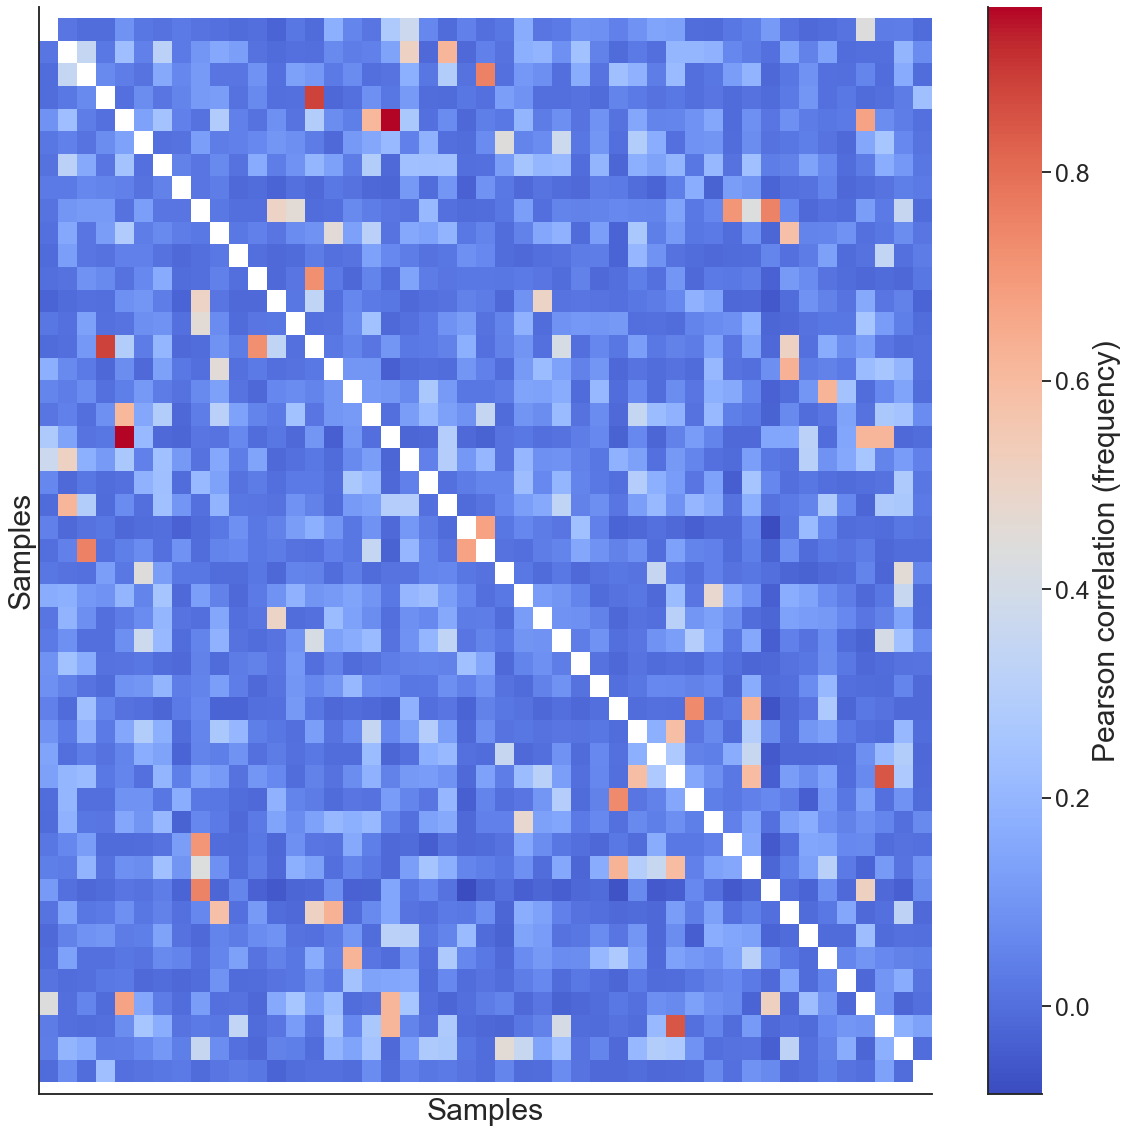

In [18]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_pearson_correlation_freq['pearson_correlation'] = df_pearson_correlation_freq['pearson_correlation'].astype(float)

result = df_pearson_correlation_freq.pivot(index='sample_2', columns='sample_1', values='pearson_correlation')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Pearson correlation (frequency)'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6g.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6g.png",bbox_inches="tight")

plt.show()

Overlap analysis 7 - Relative overlap diversity (result table)

In [19]:
columns = ['sample_1', 'sample_2', 'relative_overlap_diversity']
df_relative_overlap_diversity = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        relative_overlap_diversity = df_overlap.shape[0] / (
            df_sample1.shape[0] * df_sample2.shape[0])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'relative_overlap_diversity': relative_overlap_diversity})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'relative_overlap_diversity': relative_overlap_diversity})

    df_data = pd.DataFrame(data)
    df_relative_overlap_diversity = pd.concat(
        [df_relative_overlap_diversity, df_data], copy=False, ignore_index=True)

## FigureS6h - Relative overlap diversity

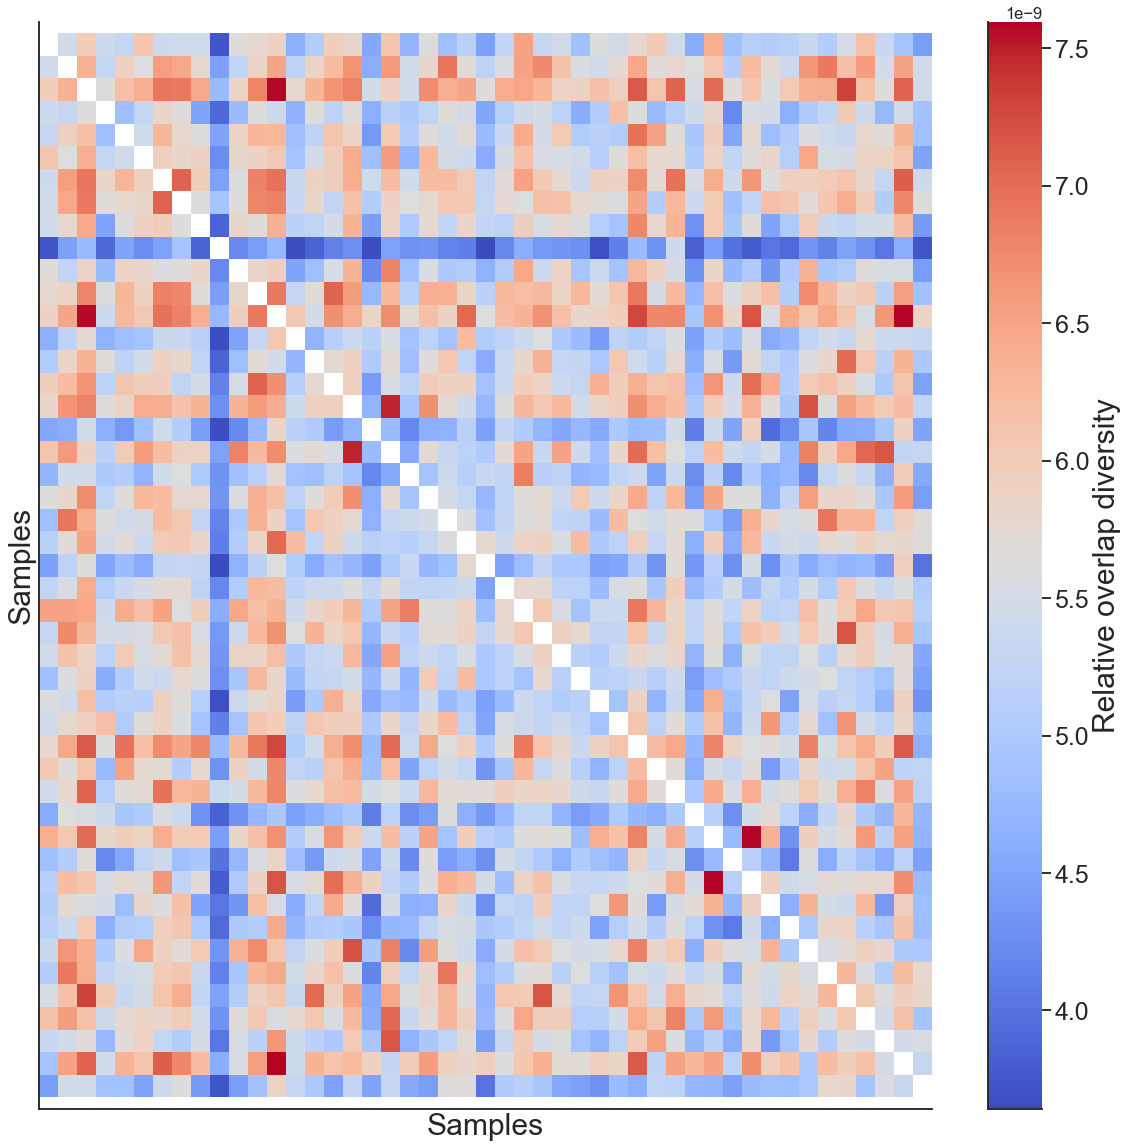

In [20]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_relative_overlap_diversity['relative_overlap_diversity'] = df_relative_overlap_diversity['relative_overlap_diversity'].astype(float)

result = df_relative_overlap_diversity.pivot(index='sample_2', columns='sample_1', values='relative_overlap_diversity')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Relative overlap diversity'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6h.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6h.png",bbox_inches="tight")

plt.show()

Overlap analysis 8 - Geometric mean of relative overlap frequencies (result table)

In [21]:
columns = ['sample_1', 'sample_2',
           'geometric_mean_of_relative_overlap_frequencies']

df_geometric_mean_of_relative_overlap_frequencies = pd.DataFrame(
    columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = (df_overlap['freq_1'].sum() * df_overlap['freq_2'].sum())**0.5

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'geometric_mean_of_relative_overlap_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'geometric_mean_of_relative_overlap_frequencies': result})

    df_data = pd.DataFrame(data)
    df_geometric_mean_of_relative_overlap_frequencies = pd.concat(
        [df_geometric_mean_of_relative_overlap_frequencies, df_data], copy=False, ignore_index=True)

## FigureS6i - Geometric mean of relative overlap frequencies

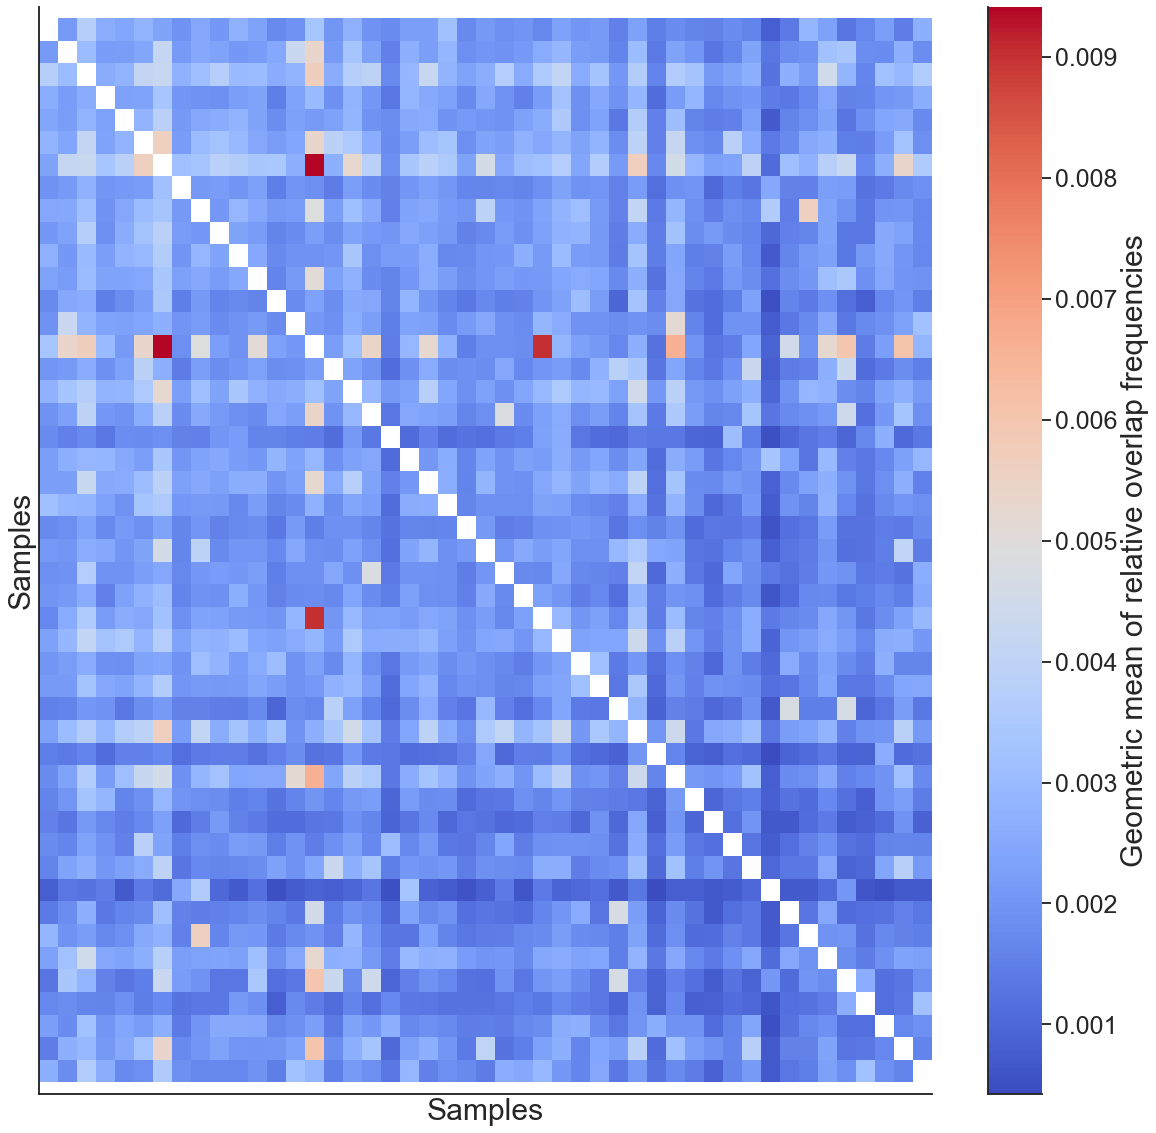

In [22]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_geometric_mean_of_relative_overlap_frequencies['geometric_mean_of_relative_overlap_frequencies'] = df_geometric_mean_of_relative_overlap_frequencies[
    'geometric_mean_of_relative_overlap_frequencies'].astype(float)

result = df_geometric_mean_of_relative_overlap_frequencies.pivot(
    index='sample_2', columns='sample_1', values='geometric_mean_of_relative_overlap_frequencies')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Geometric mean of relative overlap frequencies'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6i.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6i.png",bbox_inches="tight")

plt.show()

Overlap analysis 9 - Clonotype-wise sum of geometric mean frequencies (result table)

In [23]:
columns = ['sample_1', 'sample_2',
           'clonotype_wise_sum_of_geometric_mean_frequencies']

df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.DataFrame(
    columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = ((df_overlap['freq_1']*df_overlap['freq_2'])**0.5).sum()

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})

    df_data = pd.DataFrame(data)
    df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.concat(
        [df_clonotype_wise_sum_of_geometric_mean_frequencies, df_data], copy=False, ignore_index=True)

## FigureS6j - Clonotype-wise sum of geometric mean frequencies

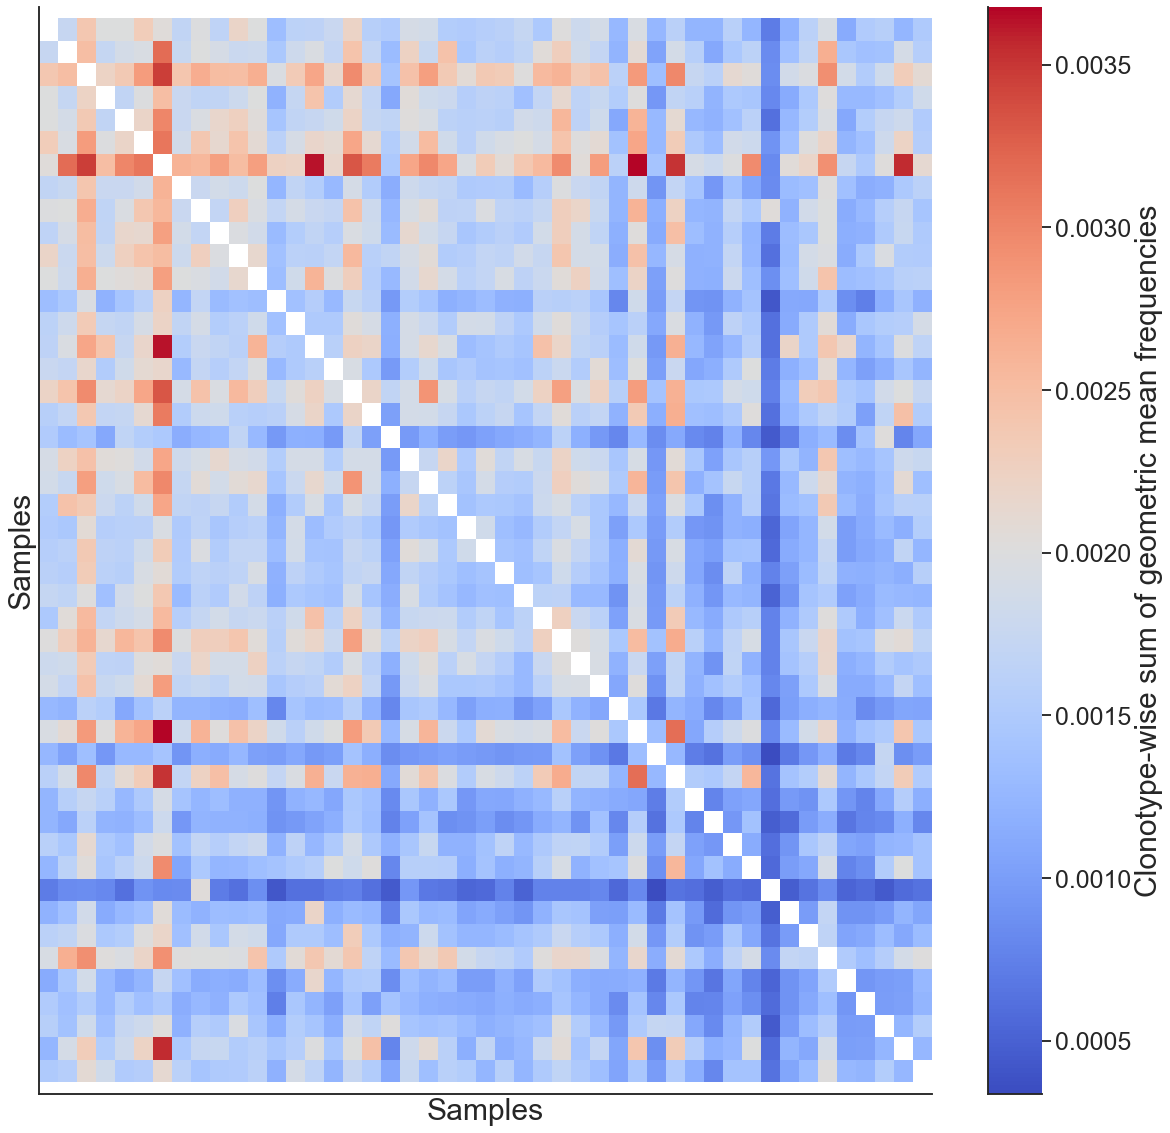

In [24]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_clonotype_wise_sum_of_geometric_mean_frequencies['clonotype_wise_sum_of_geometric_mean_frequencies'] = df_clonotype_wise_sum_of_geometric_mean_frequencies[
    'clonotype_wise_sum_of_geometric_mean_frequencies'].astype(float)

result = df_clonotype_wise_sum_of_geometric_mean_frequencies.pivot(
    index='sample_2', columns='sample_1', values='clonotype_wise_sum_of_geometric_mean_frequencies')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Clonotype-wise sum of geometric mean frequencies'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6j.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6j.png",bbox_inches="tight")

plt.show()

Overlap analysis 10 - Jensen-Shannon divergence of variable segment usage distributions (result table)

In [25]:
columns = ['sample_1', 'sample_2', 'jensen_shannon_divergence']
df_jensen_shannon_divergence = pd.DataFrame(columns=columns)


def kl_divergence(p, q):
    return -np.sum(p * np.log2(q / p))


def js_divergence(p, q):
    m = (1 / 2) * (p + q)
    return (1 / 2) * kl_divergence(p, m) + (1 / 2) * kl_divergence(q, m)


for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_sample1_v = df_sample1.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_1': 'sum'})
        df_sample2_v = df_sample2.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_2': 'sum'})

        df_JSD_combine = pd.merge(df_sample1_v, df_sample2_v, on=['v'])

        JSD_sample1 = df_JSD_combine[['sumfreq_1']].to_numpy()
        JSD_sample2 = df_JSD_combine[['sumfreq_2']].to_numpy()

        result = js_divergence(JSD_sample1, JSD_sample2)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jensen_shannon_divergence': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jensen_shannon_divergence': result})

    df_data = pd.DataFrame(data)
    df_jensen_shannon_divergence = pd.concat(
        [df_jensen_shannon_divergence, df_data], copy=False, ignore_index=True)

## FigureS6k - Jensen-Shannon divergence of variable segment usage distributions

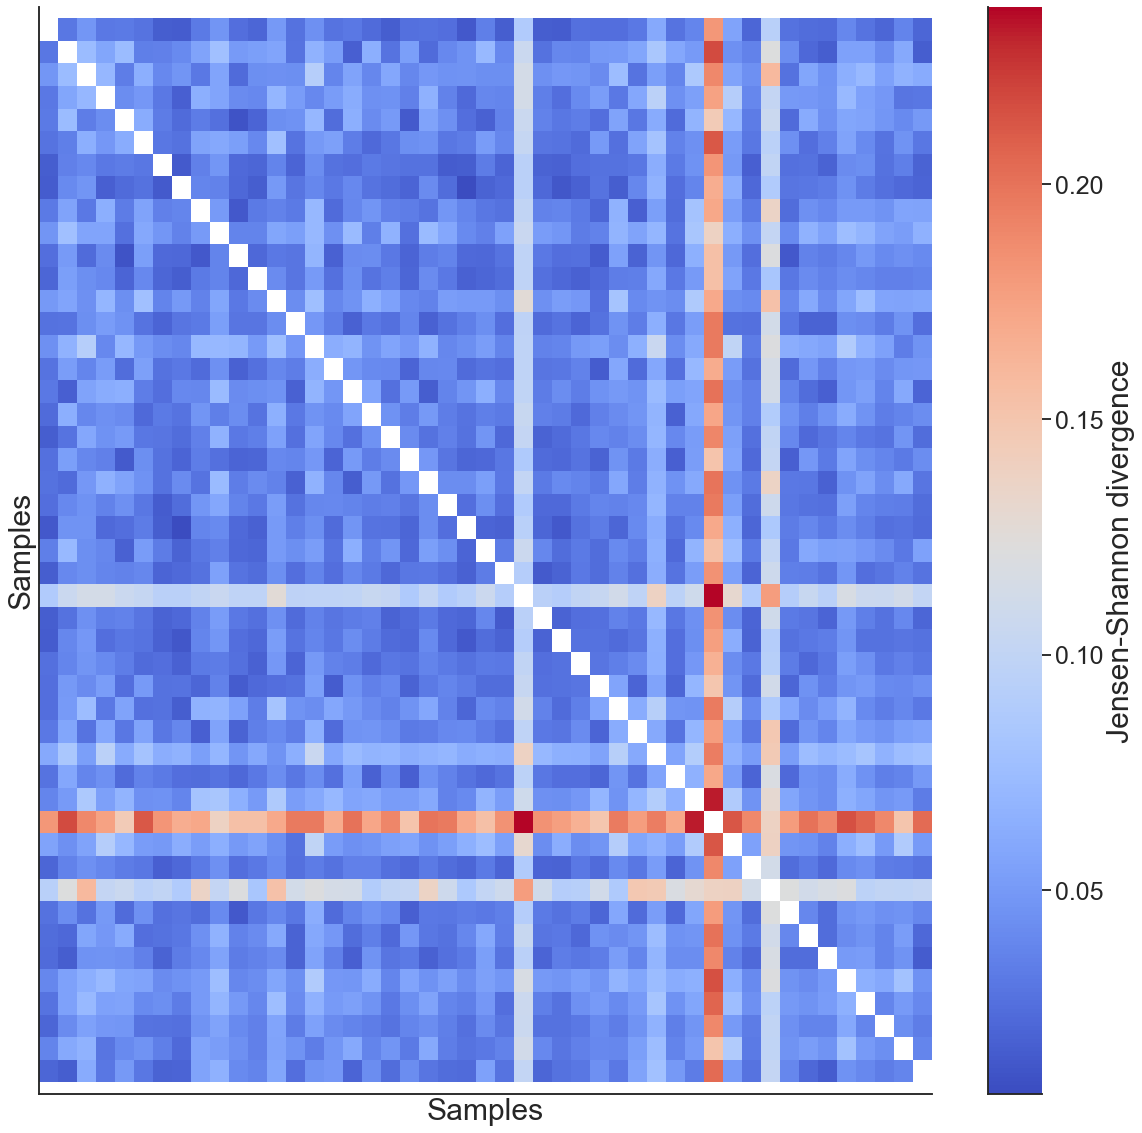

In [26]:
# Set aesthetics
%matplotlib inline
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(20,20))

# Plot the heatmap
df_jensen_shannon_divergence['jensen_shannon_divergence'] = df_jensen_shannon_divergence['jensen_shannon_divergence'].astype(
    float)

result = df_jensen_shannon_divergence.pivot(
    index='sample_2', columns='sample_1', values='jensen_shannon_divergence')

ax = sns.heatmap(result, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Jensen-Shannon divergence'})
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xlabel('Samples', fontsize=30)
ax.set_ylabel('Samples', fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

sns.despine()

plt.savefig("../figures/supplementary/figureS6k.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS6k.png",bbox_inches="tight")

plt.show()